# The following script is designed to walk through the process of finding the lowest energy conformers for molecules using RDKit's force field method

We'll start by performing step by step analysis on a single molecule, then perform this analysis on a list of molecules, and finally develop a function to do this automatically

In [1]:
import os
import sys
import logging
FORMAT = "%(filename)s:%(lineno)d %(funcName)s %(levelname)s %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

import re
import imp
import itertools
import random
import numpy as np
from numpy import array
import pandas as pd
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns


# do this before we have a chance to import openbabel!
import rdkit, rdkit.Chem.rdDistGeom, rdkit.DistanceGeometry

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
from rdkit.Chem.rdMolTransforms import *

import py3Dmol

from rmgpy.molecule import Molecule
from rmgpy.species import Species
from rmgpy.reaction import Reaction
from rmgpy.kinetics import PDepArrhenius, PDepKineticsModel

from rmgpy.data.rmg import RMGDatabase
from rmgpy.data.kinetics import KineticsDepository, KineticsRules
from rmgpy.qm.main import QMCalculator, QMSettings
from rmgpy.qm.qmdata import QMData
from rmgpy.qm.reaction import QMReaction
from rmgpy.qm.molecule import QMMolecule


/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def view_mol(mol):
    """
    A function designed to visulaize rdkit molecules
    
    Input: mol (an rdkit molecule object)
    
    Output: 3D figure of the molecule from py3Dmol
    
    """
    mb  = Chem.MolToMolBlock(mol)
    p = py3Dmol.view(width=400, height=400)
    p.addModel(mb, "sdf")
    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p.show()
    
    

# This portion is for optimization of reactants and products 

In [3]:
test_mol = Chem.AddHs(Chem.MolFromSmiles(
    "COC(=O)Cc1ccccc1CC2CC(O)C(C(=C)CC#CCC=O)C2OO"
))

AllChem.EmbedMolecule(test_mol)

view_mol(test_mol)

In [4]:
def calc_energy(mol):
    """
    A function designed to calculate the energy of a molecule or TS
    
    Input: rdkit molecule object
    
    Output: energy of the geometry calculated using rdkit's forcefield method
    """
    molprop = rdkit.Chem.ChemicalForceFields.MMFFGetMoleculeProperties(mol)
    if molprop is None:
        # Picking an arbitrarly large molecule to create a dummy mol properties forcefield object
        test_mol = Chem.AddHs(Chem.MolFromSmiles(
            "COC(=O)Cc1ccccc1CC2CC(O)C(C(=C)CC#CCC=O)C2OO"
        ))
        
        molprop = rdkit.Chem.ChemicalForceFields.MMFFGetMoleculeProperties(test_mol)
    ff = rdkit.Chem.ChemicalForceFields.MMFFGetMoleculeForceField(mol, molprop)
    return ff.CalcEnergy()

# Example with one single rotor

For this we will be looking at methoxyethane. We chose this molecule because it has three local minima for it's one torsion. For now we will just test the above functions using this molecule

In [5]:
RDMol = Chem.AddHs(Chem.MolFromSmiles(
            "CCOC"
        ))
rdkit.Chem.AllChem.EmbedMolecule(RDMol)

view_mol(RDMol)

In [6]:
print rdkit.Chem.MolToMolBlock(RDMol)
tsRDMol = rdkit.Chem.rdchem.RWMol(RDMol)

calc_energy(RDMol)



     RDKit          3D

 12 11  0  0  0  0  0  0  0  0999 V2000
    1.6100    0.2882    0.4107 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.4508   -0.5503   -0.0674 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.4221    0.1812   -0.8505 O   0  0  0  0  0  0  0  0  0  0  0  0
   -1.7131    0.2377   -0.3513 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.2927    0.5949   -0.3952 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.1615    1.1831    0.9112 H   0  0  0  0  0  0  0  0  0  0  0  0
    2.1471   -0.3225    1.1734 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.8659   -1.4315   -0.5906 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0804   -0.8810    0.8604 H   0  0  0  0  0  0  0  0  0  0  0  0
   -2.3688   -0.2692   -1.0777 H   0  0  0  0  0  0  0  0  0  0  0  0
   -2.1065    1.2623   -0.2398 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.8370   -0.2930    0.6146 H   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  3  1  0
  3  4  1  0
  1  5  1  0
  1  6  1  0
  1  7  1  0
  2  8  1  0
  2 

15.218337269805106

## This next portion will perform a conformer analysis

We'll start by recreating the molecule again

In [7]:
RDMol = Chem.AddHs(Chem.MolFromSmiles(
            "CCOC"
        ))
rdkit.Chem.AllChem.EmbedMolecule(RDMol)

view_mol(RDMol)

In [8]:
print rdkit.Chem.MolToMolBlock(RDMol)
RDMol = rdkit.Chem.rdchem.RWMol(RDMol)

calc_energy(RDMol)


     RDKit          3D

 12 11  0  0  0  0  0  0  0  0999 V2000
    1.3863   -0.1492    0.4745 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.5001   -0.0583   -0.7343 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.5679    0.8024   -0.5808 O   0  0  0  0  0  0  0  0  0  0  0  0
   -1.6418    0.2567    0.0919 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.8707    0.1249    1.4239 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.7737   -1.1902    0.6089 H   0  0  0  0  0  0  0  0  0  0  0  0
    2.2757    0.4970    0.4184 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.1737   -1.0718   -1.0567 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.1272    0.3469   -1.5671 H   0  0  0  0  0  0  0  0  0  0  0  0
   -2.2649   -0.4209   -0.5130 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.3333   -0.2449    1.0367 H   0  0  0  0  0  0  0  0  0  0  0  0
   -2.2995    1.1074    0.3975 H   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  3  1  0
  3  4  1  0
  1  5  1  0
  1  6  1  0
  1  7  1  0
  2  8  1  0
  2 

11.327352806650646

### Now we're going to find the indicies of the atoms participating in the torsion

In [9]:

torsion_list = []

for bond1 in RDMol.GetBonds():
    
    atom1 = bond1.GetBeginAtom()
    atom2 = bond1.GetEndAtom()
    if atom1.IsInRing() or atom2.IsInRing() or atom1.GetAtomicNum() == 1 or atom2.GetAtomicNum() == 1:
        # Making sure that the atoms we're looking at are
        # not hydrogen or in a ring
        continue
    
    bond_list1 = list(atom1.GetBonds())
    bond_list2 = list(atom2.GetBonds())

    if not len(bond_list1) > 1 and not len(bond_list2) > 1:
        # Making sure that there are more than one bond attached to
        # the atoms we're looking at
        continue
        

    # Getting the 0th and 3rd atom and encuring that atoms 
    # attached to the 1st and 2nd atom are not all hydrogens
    # If not, we append a tuple of the torsion our torsion_list
    atom_count0 = 0
    hydrogen_count0 = 0
    
    for bond0 in bond_list1:
        atomX = bond0.GetOtherAtom(atom1)
        if atomX.GetIdx() != atom2.GetIdx():
            atom0 = atomX
            atom_count0 += 1
        if atomX.GetAtomicNum() == 1:
            hydrogen_count0 += 1
            
    atom_count1 = 0
    hydrogen_count1 = 0
            
    for bond2 in bond_list2:
        atomY = bond2.GetOtherAtom(atom2)
        if atomY.GetIdx() != atom1.GetIdx():
            atom3 = atomY
            atom_count1 += 1
        if atomY.GetAtomicNum() == 1:
            hydrogen_count1 += 1
            
    if atom_count0 != hydrogen_count0 and atom_count1 != hydrogen_count1:
        torsion_tup = (atom0.GetIdx(), atom1.GetIdx(), atom2.GetIdx(), atom3.GetIdx())
        torsion_list.append(torsion_tup)
    
torsion_list

[(8, 1, 2, 3)]

### Now we will loop through torsion angles ranging between 0 degrees to 360 degrees using increments of 10 degrees. We will calculate the enegy at each step and create a list of lists containing the energy and the torsion angle

In [10]:
torsion_angles = np.arange(0, 360+10,10)
torsion_combos = list( itertools.combinations_with_replacement( torsion_angles, len(torsion_list)) )
torsion_combos = torsion_combos + list(itertools.combinations_with_replacement( torsion_angles[::-1], len(torsion_list)) )

df = []


torsion_combos
tup = RDMol.GetConformers()
conformer = tup[0]
for combo in torsion_combos:
    

    geometry = zip(torsion_list, combo)
    
    for torsion in geometry:
        i = torsion[0][0]
        j = torsion[0][1]
        k = torsion[0][2]
        l = torsion[0][3]
        angle = torsion[1]
        
        SetDihedralDeg(conformer,
                       i, 
                       j, 
                       k, 
                       l,
                       angle)
    
    df.append( [calc_energy(RDMol)] + list(combo))
    


In [11]:
df

[[14.046202647292546, 0],
 [13.683102499678498, 10],
 [12.993056968883403, 20],
 [12.144295182956586, 30],
 [11.337688447060973, 40],
 [10.764724434802522, 50],
 [10.55944845820815, 60],
 [10.756414653139228, 70],
 [11.273773592173956, 80],
 [11.935886256640384, 90],
 [12.531936168504123, 100],
 [12.884676550588646, 110],
 [12.898660823725693, 120],
 [12.578574184109165, 130],
 [12.032148147297388, 140],
 [11.481065666103984, 150],
 [11.310881171305324, 160],
 [12.17772055985489, 170],
 [15.057456159486982, 180],
 [20.863297340900903, 190],
 [28.738523099110896, 200],
 [34.07375655891362, 210],
 [33.323276663508246, 220],
 [29.485614234895056, 230],
 [26.02241415673483, 240],
 [23.31949339410657, 250],
 [20.674838889477765, 260],
 [17.747505399594463, 270],
 [14.926101333675811, 280],
 [12.821654097069256, 290],
 [11.712903753901047, 300],
 [11.516288763029385, 310],
 [11.968806904927732, 320],
 [12.741560541810431, 330],
 [13.50159747695124, 340],
 [13.983383827484142, 350],
 [14.0462

In [12]:
i, j , k, l

(8, 1, 2, 3)

In [13]:
df = pd.DataFrame(df)
columns = ["Energy"]
for i in range(len(torsion_list)):
    columns.append("Tor " + str(i))

df.columns = columns

df.sort("Energy")

/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Energy,Tor 0
67,10.559448,60
6,10.559448,60
66,10.756415,70
7,10.756415,70
68,10.764724,50
5,10.764724,50
65,11.273774,80
8,11.273774,80
57,11.310881,160
16,11.310881,160


### Finally we visualize the data

Also, our findings for this conformer analysis are similar to that of `http://onlinelibrary.wiley.com/doi/10.1002/jcc.10271/full`

/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


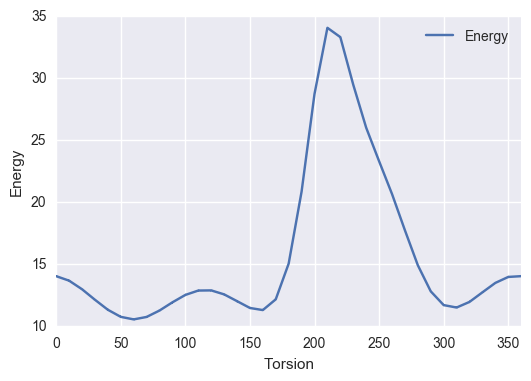

In [14]:
plot = df.sort("Tor 0").plot("Tor 0")
plot.set_ylabel("Energy")
plot.set_xlabel("Torsion")


# This next portion is designed to do the above but for a variety of molecules

For this we are looking at a series of 5 molecules with a variety geometries

In [15]:
list_of_smiles = [
    'CCCC',
    'CCC#CC',
    'CCC=CCC',
    'CCOC',
    "CCCC1(CCC)OCC(C)C1"
]

for smiles in list_of_smiles:
    RDMol = Chem.AddHs(Chem.MolFromSmiles(
            smiles
        ))
    rdkit.Chem.AllChem.EmbedMolecule(RDMol)

    #print view_mol(RDMol)

    
    print rdkit.Chem.MolToMolBlock(RDMol)
    print
    RDMol = rdkit.Chem.rdchem.RWMol(RDMol)
    torsion_list = []

    for bond1 in RDMol.GetBonds():

        atom1 = bond1.GetBeginAtom()
        atom2 = bond1.GetEndAtom()
        if atom1.IsInRing() or atom2.IsInRing() or atom1.GetAtomicNum() == 1 or atom2.GetAtomicNum() == 1:
            # Making sure that the atoms we're looking at are
            # not hydrogen or in a ring
            continue

        bond_list1 = list(atom1.GetBonds())
        bond_list2 = list(atom2.GetBonds())

        if not len(bond_list1) > 1 and not len(bond_list2) > 1:
            # Making sure that there are more than one bond attached to
            # the atoms we're looking at
            continue


        # Getting the 0th and 3rd atom and encuring that atoms 
        # attached to the 1st and 2nd atom are not all hydrogens
        # If not, we append a tuple of the torsion our torsion_list
        atom_count0 = 0
        hydrogen_count0 = 0

        for bond0 in bond_list1:
            atomX = bond0.GetOtherAtom(atom1)
            if atomX.GetIdx() != atom2.GetIdx():
                atom0 = atomX
                atom_count0 += 1
            if atomX.GetAtomicNum() == 1:
                hydrogen_count0 += 1

        atom_count1 = 0
        hydrogen_count1 = 0

        for bond2 in bond_list2:
            atomY = bond2.GetOtherAtom(atom2)
            if atomY.GetIdx() != atom1.GetIdx():
                atom3 = atomY
                atom_count1 += 1
            if atomY.GetAtomicNum() == 1:
                hydrogen_count1 += 1

        if atom_count0 != hydrogen_count0 and atom_count1 != hydrogen_count1:
            torsion_tup = (atom0.GetIdx(), atom1.GetIdx(), atom2.GetIdx(), atom3.GetIdx())
            torsion_list.append(torsion_tup)
    print torsion_list
        
        
        

    torsion_angles = np.arange(0, 360+30,30)
    torsion_combos = list( itertools.combinations_with_replacement( torsion_angles, len(torsion_list)) )
    torsion_combos = torsion_combos + list(itertools.combinations_with_replacement( torsion_angles[::-1], len(torsion_list)) )

    df = []

    
    tup = RDMol.GetConformers()
    conformer = tup[0]
    for combo in torsion_combos:


        geometry = zip(torsion_list, combo)

        for torsion in geometry:
            i = torsion[0][0]
            j = torsion[0][1]
            k = torsion[0][2]
            l = torsion[0][3]
            angle = torsion[1]

            SetDihedralDeg(conformer,
                           i, 
                           j, 
                           k, 
                           l,
                           angle)
        
        df.append( [calc_energy(RDMol), RDMol] + list(combo))
        

    df = pd.DataFrame(df)
    columns = ["Energy", "RDMol"]
    for i in range(len(torsion_list)):
        columns.append("Tor " + str(i))

    df.columns = columns

    print df.sort("Energy").iloc[0]
    print df.sort("Energy").iloc[0]["RDMol"]
    print
    
    print rdkit.Chem.MolToMolBlock(RDMol)
    print
    print


     RDKit          3D

 14 13  0  0  0  0  0  0  0  0999 V2000
    1.8773    0.1861   -0.0893 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.5114   -0.0026    0.5361 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.5298   -0.4497   -0.4475 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.8465    0.1586   -0.0156 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.3110   -0.7581   -0.4711 H   0  0  0  0  0  0  0  0  0  0  0  0
    2.5074    0.6560    0.7079 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.8616    0.8941   -0.9416 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.2250    0.9592    0.9957 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.6359   -0.7587    1.3440 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.6590   -1.5570   -0.3765 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.2676   -0.2350   -1.4926 H   0  0  0  0  0  0  0  0  0  0  0  0
   -2.4532    0.3963   -0.9196 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.7132    1.0773    0.5968 H   0  0  0  0  0  0  0  0  0  0  0  0
   -2.4602   -0.5664    0

/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/ipykernel/__main__.py:112: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/ipykernel/__main__.py:113: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


[(10, 1, 2, 11), (11, 2, 3, 12), (12, 3, 4, 14)]
Energy                                            25.1029
RDMol     <rdkit.Chem.rdchem.RWMol object at 0x1139a6838>
Tor 0                                                  60
Tor 1                                                 150
Tor 2                                                 300
Name: 204, dtype: object


     RDKit          3D

 18 17  0  0  0  0  0  0  0  0999 V2000
   -2.4699    0.7097    0.5487 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.9540   -0.3032   -0.4451 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.4939   -0.0589   -0.5836 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.2618    0.3789    0.4330 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.4219   -0.6128    1.5477 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.5295   -0.1373    2.6427 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.4248    1.7091    0.0517 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.8082    0.7095    1.4512 H   0  0  0  0  0  0  0  0  0  0  0  0
   -3.4966

## The following functions should be what you need to get the lowest energy conformer

Moving forward one should just need to use the following function to get the minimum energy by force field optimization via RDkit

In [16]:

def get_lowest_energy_conformer(smiles):
    RDMol = Chem.AddHs(Chem.MolFromSmiles(
            smiles
        ))
    rdkit.Chem.AllChem.EmbedMolecule(RDMol)

    view_mol(RDMol)
    
    RDMol = rdkit.Chem.rdchem.RWMol(RDMol)
    
    torsion_list = []
    for bond1 in RDMol.GetBonds():
        atom1 = bond1.GetBeginAtom()
        atom2 = bond1.GetEndAtom()
        if atom1.IsInRing() or atom2.IsInRing() or atom1.GetAtomicNum() == 1 or atom2.GetAtomicNum() == 1:
            # Making sure that the atoms we're looking at are
            # not hydrogen or in a ring
            continue

        bond_list1 = list(atom1.GetBonds())
        bond_list2 = list(atom2.GetBonds())

        if not len(bond_list1) > 1 and not len(bond_list2) > 1:
            # Making sure that there are more than one bond attached to
            # the atoms we're looking at
            continue


        # Getting the 0th and 3rd atom and encuring that atoms 
        # attached to the 1st and 2nd atom are not all hydrogens
        # If not, we append a tuple of the torsion our torsion_list
        atom_count0 = 0
        hydrogen_count0 = 0

        for bond0 in bond_list1:
            atomX = bond0.GetOtherAtom(atom1)
            if atomX.GetIdx() != atom2.GetIdx():
                atom0 = atomX
                atom_count0 += 1
            if atomX.GetAtomicNum() == 1:
                hydrogen_count0 += 1

        atom_count1 = 0
        hydrogen_count1 = 0

        for bond2 in bond_list2:
            atomY = bond2.GetOtherAtom(atom2)
            if atomY.GetIdx() != atom1.GetIdx():
                atom3 = atomY
                atom_count1 += 1
            if atomY.GetAtomicNum() == 1:
                hydrogen_count1 += 1

        if atom_count0 != hydrogen_count0 and atom_count1 != hydrogen_count1:
            torsion_tup = (atom0.GetIdx(), atom1.GetIdx(), atom2.GetIdx(), atom3.GetIdx())
            torsion_list.append(torsion_tup)

    torsion_angles = np.arange(0, 360+30,30)
    torsion_combos = list( itertools.combinations_with_replacement( torsion_angles, len(torsion_list)) )
    torsion_combos = torsion_combos + list(itertools.combinations_with_replacement( torsion_angles[::-1], len(torsion_list)) )

    df = []

    tup = RDMol.GetConformers()
    conformer = tup[0]
    for combo in torsion_combos:


        geometry = zip(torsion_list, combo)

        for torsion in geometry:
            i = torsion[0][0]
            j = torsion[0][1]
            k = torsion[0][2]
            l = torsion[0][3]
            angle = torsion[1]

            SetDihedralDeg(conformer,
                           i, 
                           j, 
                           k, 
                           l,
                           angle)
        
        df.append( [calc_energy(RDMol), RDMol] + list(combo))
        
        
    df = pd.DataFrame(df)
    columns = ["Energy", "RDMol"]
    for i in range(len(torsion_list)):
        columns.append("Tor " + str(i))

    df.columns = columns
    
    lowest_E_mol = df.sort("Energy").iloc[0]["RDMol"]
    print rdkit.Chem.MolToMolBlock(lowest_E_mol)

    rdkit.Chem.AddHs(lowest_E_mol)
    rdkit.Chem.AllChem.UFFOptimizeMolecule(lowest_E_mol)
    
    #rdkit.Chem.AllChem.EmbedMolecule(lowest_E_mol)
    return lowest_E_mol
    
    

In [17]:

lowest_E = get_lowest_energy_conformer("CCOCC(=O)OCC")
#lowest_E = get_lowest_energy_conformer("COC(=O)Cc1ccccc1CC2CC(O)C(C(=C)CC#CCC=O)C2OO")
view_mol(lowest_E)


     RDKit          3D

 21 20  0  0  0  0  0  0  0  0999 V2000
   -3.8079   -0.3526   -0.3087 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.8246    0.7918   -0.2757 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.8410    0.6376    0.6822 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.6055    0.6201    0.0652 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.1885   -0.5912    0.3587 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.4616   -1.0060    1.5081 O   0  0  0  0  0  0  0  0  0  0  0  0
    0.6305   -1.3818   -0.6995 O   0  0  0  0  0  0  0  0  0  0  0  0
    1.3467   -2.5850   -0.5025 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.6509   -2.4445   -1.2620 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.4557   -1.1911    0.3209 H   0  0  0  0  0  0  0  0  0  0  0  0
   -3.9620   -0.7108   -1.3583 H   0  0  0  0  0  0  0  0  0  0  0  0
   -4.8080   -0.0420    0.0816 H   0  0  0  0  0  0  0  0  0  0  0  0
   -3.3536    1.7521   -0.0992 H   0  0  0  0  0  0  0  0  0  0  0  0
   -2.3420    0.8590   -1

/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/ipykernel/__main__.py:96: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
